# スクラッチでハードマージンサポートベクターマシンを実装する。

- import

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='feature1', ylabel='feature2', target_names=['1', '-1']):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

- サンプルデータセットの作成

In [50]:
X, y = make_blobs(n_samples=3, centers=2, n_features=2,random_state=0, cluster_std=0.5)
y = np.where(y==0,-1, y)

In [51]:
X, y= np.array([[1,4],[3,4],[4,1]]),np.array([1,1,-1])

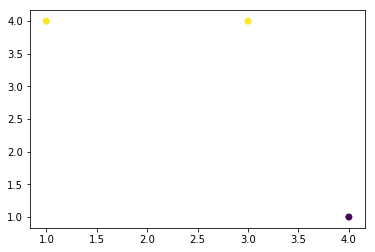

In [52]:
plt.scatter(X[:,0],X[:,1], c=y);

In [53]:
X

array([[1, 4],
       [3, 4],
       [4, 1]])

In [54]:
y

array([ 1,  1, -1])

## カーネル関数の作成   
  - 線形カーネル  $k(x_i, x_j) = x_{i}^{T} x_j$  
  - 多項式カーネル  $k(x_i, x_j) = \gamma(x_{i}^{T} x_j + \theta_0)^{d}$  
  

線形カーネルは、多項式カーネルにおける$\gamma=1, \theta_0=0, d=1$の時である。

- 線形カーネルを実装する。

In [55]:
def kernel(X, y):
    return np.dot(X, y.T)

In [56]:
kernel(X,X)

array([[17, 19,  8],
       [19, 25, 16],
       [ 8, 16, 17]])

- 多項式カーネルを実装（線形カーネルも含める）

In [57]:
X

array([[1, 4],
       [3, 4],
       [4, 1]])

行列の積をとり定数倍する。。

In [58]:
3*np.dot(X, X.T)

array([[51, 57, 24],
       [57, 75, 48],
       [24, 48, 51]])

バイアス項をとる。

In [59]:
3*np.dot(X, X.T)+np.array([1])

array([[52, 58, 25],
       [58, 76, 49],
       [25, 49, 52]])

これをべき乗する。

In [60]:
3*np.power(np.dot(X, X.T)+np.array([1]),2)

array([[ 972, 1200,  243],
       [1200, 2028,  867],
       [ 243,  867,  972]])

パラメータを一般化して関数化する。  

In [61]:
def poly_kernel(X,y,gannma=1, theta=0, d=1):
    return np.power(np.dot(X, y.T)+np.array([theta]), d)

In [62]:
poly_kernel(X,X)

array([[17, 19,  8],
       [19, 25, 16],
       [ 8, 16, 17]])

## ラグランジュの未定乗数法による最急降下法で解く
$\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})$

In [63]:
X

array([[1, 4],
       [3, 4],
       [4, 1]])

- サンプルの数だけラムダを用意する。

In [64]:
n_lambda = np.array([1,2,3])
n_lambda

array([1, 2, 3])

- サンプル数をiとすると、kernelによって$i\times i$の対称行列ができる。

In [65]:
kernel(X,X)

array([[17, 19,  8],
       [19, 25, 16],
       [ 8, 16, 17]])

- 上の行列にラムダをかけて、列ごとにラムダ倍する。

In [66]:
n_lambda*kernel(X, X)

array([[17, 38, 24],
       [19, 50, 48],
       [ 8, 32, 51]])

- さらに$y_j$成分をかける。

In [67]:
y_j = y
kernel(X, X)*n_lambda*y_j

array([[ 17,  38, -24],
       [ 19,  50, -48],
       [  8,  32, -51]])

- 対角行列との積をとって、行ごとにyをかける。

In [68]:
y_i = np.diag(y)
y_i

array([[ 1,  0,  0],
       [ 0,  1,  0],
       [ 0,  0, -1]])

In [69]:
np.dot(y_i,kernel(X, X)*n_lambda*y_j)

array([[ 17,  38, -24],
       [ 19,  50, -48],
       [ -8, -32,  51]])

- 横方向に和をとる

In [70]:
np.sum(np.dot(y_i, kernel(X, X)*n_lambda*y_j),axis=1)

array([31, 21, 11])

- 更新式通り実装する

In [71]:
n_lambda = np.ones(X.shape[0])#np.arange(1,4,1)
y_i = np.diag(y)
y_j = y
alpha = 0.01
grad = 1-sum(np.dot(y_i,kernel(X, X)*n_lambda*y_j))
grad
n_lambda = n_lambda + alpha*grad

In [72]:
n_lambda

array([0.73, 0.73, 1.08])

## サポートベクターの決定
ラムダが設定した閾値よりも大きくなったサンプルをサポートベクターとする。  
また、KKT条件より更新の過程でマイナスになったn_lambdaは０にする。

In [75]:
n_lambda = np.ones(X.shape[0])#np.arange(1,4,1)
y_i = np.diag(y)
y_j = y
alpha = 0.001
simirality = np.dot(y_i, kernel(X, X)*y_j)

# ラムダの更新
for i in range(1000000):
    grad = 1 - np.sum(n_lambda*simirality,axis=1)
    n_lambda = n_lambda + alpha*grad
    n_lambda = np.where(n_lambda < 0, 0, n_lambda)
    
# support vectorをindexから取得
sv_i = np.where(n_lambda>1e-5)[0]
sup_vec = X[sv_i]
sup_lambda = n_lambda[sv_i]
sup_y = y[sv_i]



simirality = np.dot(y_i, kernel(X, X)*y_j)
for i in range(10000):
    grad = 1 - np.sum(n_lambda*simirality,axis=1)
    n_lambda = n_lambda + alpha*grad
    n_lambda = np.where(n_lambda < 0, 0, n_lambda)

In [76]:
sup_vec

array([[3, 4],
       [4, 1]])

## 推定
サポートベクターを使って、予測する。出力結果の符号が予測結果である。  
$y(x) = \sum_{n=1}^{N}\lambda_n y_n k(x, s_n)$

In [27]:
y_pred = np.dot(sup_lambda*sup_y,kernel(sup_vec, X))
y_pred = np.where(y_pred>0,1,-1)

In [28]:
y_pred

array([ 1,  1, -1])

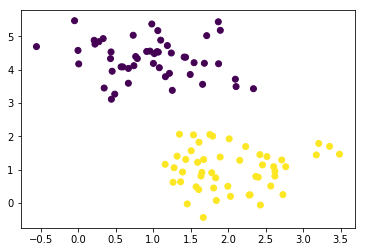

In [29]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2,random_state=0, cluster_std=0.6)
y = np.where(y==0,-1, y)
plt.scatter(X[:,0],X[:,1], c=y)

## クラス化

In [30]:
class ScratchSVMClassifier():
    def __init__(self, alpha = 0.001, threshold=1e-5, n_iter=10000):
        self.alpha = alpha
        self.threshold = threshold
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.n_lambda = np.ones(X.shape[0])
        y_i = np.diag(y)
        y_j = y
        simirality = np.dot(y_i, kernel(X, X)*y_j)
        for i in range(self.n_iter):
            grad = 1 - np.sum(self.n_lambda*simirality,axis=1)
            self.n_lambda = self.n_lambda + self.alpha*grad
            self.n_lambda = np.where(self.n_lambda < 0, 0, self.n_lambda)
        sv_i = np.where(self.n_lambda>self.threshold)[0]
        self.sup_vec = X[sv_i]
        self.sup_lambda = self.n_lambda[sv_i]
        self.sup_y = y[sv_i]
        self.sup_lambda*self.sup_y*kernel(X, self.sup_vec)
        
    def predict(self, X):
        y_pred = np.dot(self.sup_lambda*self.sup_y,kernel(self.sup_vec, X))
        return np.where(y_pred>0,1,-1)

In [31]:
clf = ScratchSVMClassifier(alpha = 0.0001, threshold=1e-5, n_iter=10000)

In [32]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0= [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [33]:
X.shape

(500, 2)

In [34]:
clf.fit(X,y)

In [35]:
clf.predict(X)

array([-1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,
        1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
        1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,
        1,  1, -1,  1,  1

In [36]:
clf.sup_vec

array([[-1.02829008,  0.23898594],
       [-0.97854994,  0.34188908],
       [-0.50179779,  0.74466058],
       [ 0.67098941, -0.58384118],
       [ 0.14096048,  1.74864676],
       [ 0.31369184,  1.90748822]])

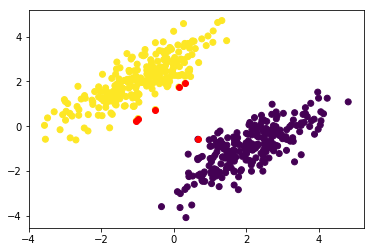

In [37]:
plt.scatter(X[:,0],X[:,1], c=y)
plt.scatter(clf.sup_vec[:,0],clf.sup_vec[:,1], c='r');

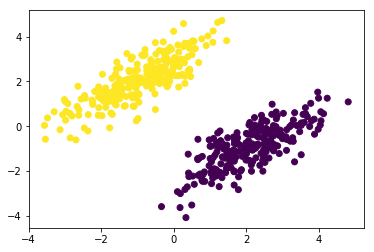

In [38]:
plt.scatter(X[:,0],X[:,1], c=y);

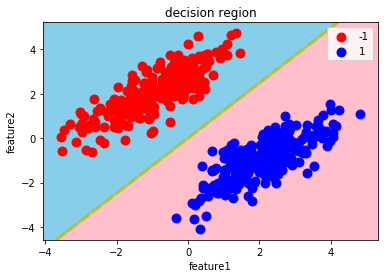

In [39]:
 decision_region(X, y, clf, step=0.01, title='decision region', xlabel='feature1', ylabel='feature2', target_names=['-1', '1'])

TODO：SMOの実装

In [40]:
"""
irisデータを読み込むコード
"""

from sklearn.datasets import load_iris
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_iris()
df_X = DataFrame(data=data.data, columns=pd.Index(["sepal_length", "sepal_width", "petal_length", "petal_width"]))
df_y = DataFrame(data=data.target, columns=pd.Index(["Target"]))
df_X =df_X[["sepal_length", "petal_length"]]
df_train= df_X.join(df_y).query("Target == [1, 2]")
X = df_train.drop("Target", axis=1).values
y = df_train[["Target"]].values

(X_train, X_val, y_train, y_val) = train_test_split(X, y, test_size=0.3)

#ラベルを1or2から−1or1に置き換える
y_train = np.where(y_train==1, -1, 1)
y_val = np.where(y_val==1, -1, 1)
# y_val = 

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)


In [41]:
clf = ScratchSVMClassifier(alpha = 0.0001, threshold=1e-5, n_iter=10000)

In [42]:
clf.fit(X_train,y_train.flatten())

In [43]:
clf.predict(X_train)

array([ 1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,
       -1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
       -1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1,
       -1, -1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,
        1,  1])

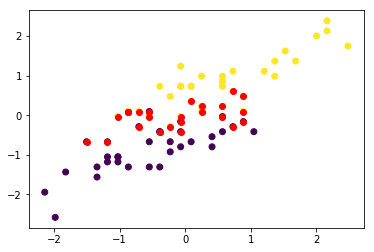

In [44]:
plt.scatter(X_train[:,0],X_train[:,1], c=y_train.flatten())
plt.scatter(clf.sup_vec[:,0],clf.sup_vec[:,1], c='r');

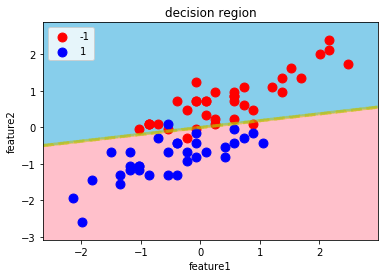

In [45]:
decision_region(X_train, y_train.flatten(), clf, step=0.01, title='decision region', xlabel='feature1', ylabel='feature2', target_names=['-1', '1'])

In [46]:
np.dot(y, y.T)

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4]])

In [47]:
c=2
def add(a,b):
    d = a+b+c
    return d

In [48]:
add(3,4)

9